# IMAGE MOSAICING 

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import sys
from numpy import linalg

def findH12(pts1, pts2):
    A=np.empty(shape=(0,9))    
    for i in range(0, len(pts1)):
        x1 = pts1[i,0]
        y1 = pts1[i,1]
        x2 = pts2[i,0]
        y2 = pts2[i,1]
        A = np.append(A,[[x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2]], axis=0)
        A = np.append(A, [[0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2]], axis=0)

    u,d,v=linalg.svd(A)
    H=v[-1]
    H=H/H[-1]
    H=H.reshape(3,-1)
    return H

def findHomography(pts1, pts2):

    listOf1 = np.array([1]*np.shape(pts1)[0]).reshape(-1,1)
    pts1Homogenous=np.append(pts1, listOf1, axis=1)
    pts2Homogenous=np.append(pts2, listOf1, axis=1)
    
    minError=sys.maxsize
    bestH=0
    for it in range(0,500):
        try:
            selectedRows=np.random.choice(np.shape(pts1)[0], 16, replace=False)
        except ValueError:
            try:
                selectedRows=np.random.choice(np.shape(pts1)[0], 4, replace=False)
            except ValueError:
                print('Not Enough Matches')
                return None
        selectedPts1=pts1[selectedRows]
        selectedPts2=pts2[selectedRows]
        H=findH12(selectedPts1, selectedPts2)
        
        error=0
        myPts2=[]
        for i in selectedRows:
            pt=np.dot(H, pts1Homogenous[i])
            if(pt[-1]!=0):
                pt=pt/pt[-1]
            myPts2.append(pt)
            
        myPts2=np.array(myPts2)
        error=linalg.norm(myPts2[:,:-1]-selectedPts2)/len(selectedPts2)

        if(error<minError):
            minError=error
            bestH=H
            
#     print("Reconstruction Error: ",minError)
#     print("\Homography Matrix:\n",bestH)
    return bestH

def joinImages(img1, img2, leftRight):
    sift = cv.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp1 = np.float32([i.pt for i in kp1])

    kp2, des2 = sift.detectAndCompute(img2,None)
    kp2 = np.float32([i.pt for i in kp2])
    
    matcher = cv.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(des1, des2, 2)
    matches = []
    ratio=0.7
    for match in rawMatches:
        if len(match) == 2 and match[0].distance < match[1].distance * ratio:
            matches.append((match[0].trainIdx, match[0].queryIdx))   

    if(len(matches)>4):
        pts1=np.float32([kp1[i] for(_,i) in matches])
        pts2=np.float32([kp2[i] for(i,_) in matches])

#         H,status=cv.findHomography(pts2, pts1, cv.RANSAC, 3)
        H = findHomography(pts2, pts1)
        if H is None:
            return None
    if(leftRight==False):
        dst=cv.warpPerspective(img2, H, (img1.shape[1], img1.shape[0] + img2.shape[0]))
    else:
        dst=cv.warpPerspective(img2, H, (img2.shape[1]+img1.shape[1], img1.shape[0]))
    plt.figure(figsize=(10,10))
    plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
    plt.title('Warped Image')
    plt.show()
    dst[0:img1.shape[0], 0:img1.shape[1]] = img1
    if dst is None:
        pass
    else:
        dst = removeBlackPixels(dst)
        plotJoinedImg(dst)
    return dst
        
def removeBlackPixels(img):
    b=np.sum(img, axis=0)
    b=np.sum(b, axis=1)

    c=np.nonzero(b<35*3*img.shape[0])[0]
    lastIndex=len(c)-1
    while(lastIndex>0 and c[lastIndex-1]==c[lastIndex]-1):
        lastIndex-=1
    try:
        img=img[:, :c[lastIndex]]
    except IndexError:
        pass
    return img

def plotJoinedImg(img):
    plt.figure(figsize=(10,10))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Joined Image')
    plt.show()    

### Image Set 1

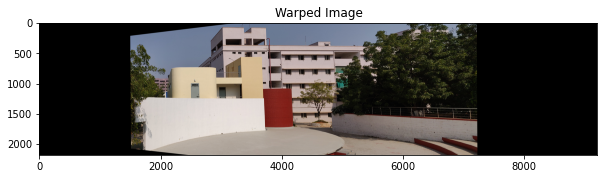

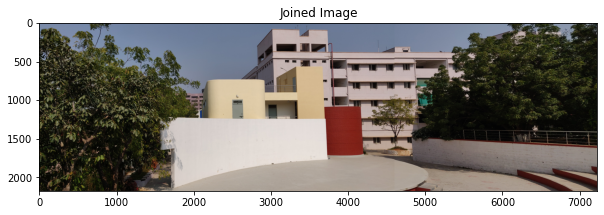

In [2]:
img1 = cv.imread('../images/Image Mosaicing/1_1.jpg')
img2 = cv.imread('../images/Image Mosaicing/1_2.jpg')
img1 = joinImages(img1, img2, True)

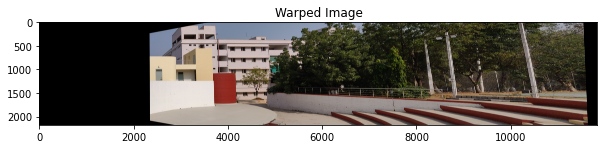

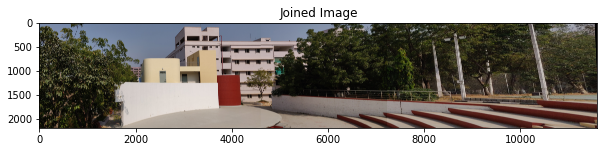

True

In [3]:
img2 = cv.imread('../images/Image Mosaicing/1_3.jpg')
img1 = joinImages(img1, img2, True)

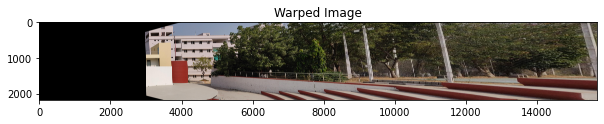

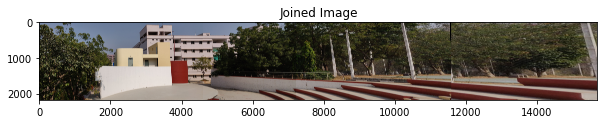

In [4]:
img2 = cv.imread('../images/Image Mosaicing/1_4.jpg')
img1 = joinImages(img1, img2, True)

### Image Set 2

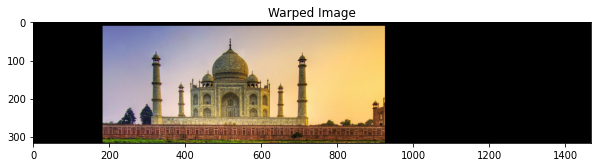

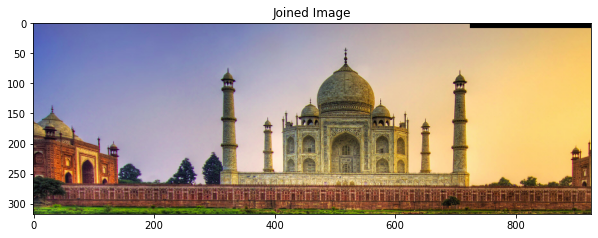

In [5]:
img1 = cv.imread('../images/Image Mosaicing/2_1.png')
img2 = cv.imread('../images/Image Mosaicing/2_2.png')
img1 = joinImages(img1, img2, True)

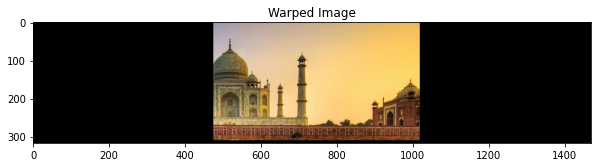

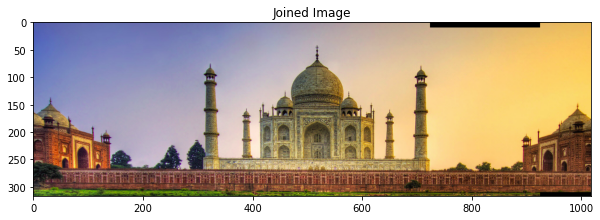

In [6]:
img2 = cv.imread('../images/Image Mosaicing/2_3.png')
img1 = joinImages(img1, img2, True)

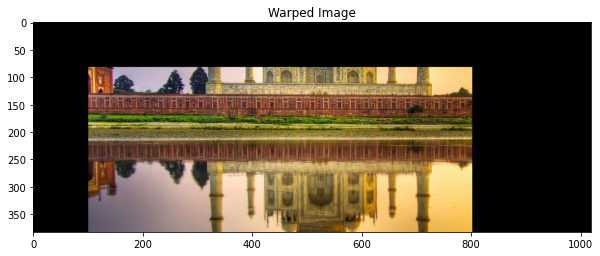

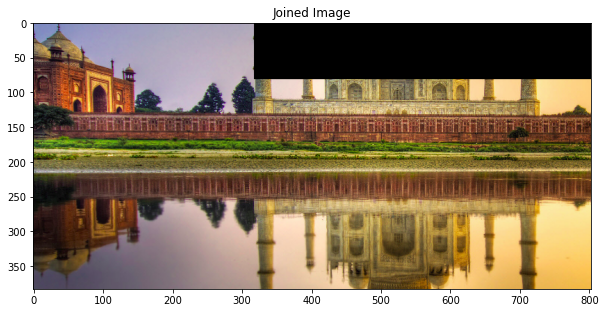

In [7]:
upper=img1.copy()
img1 = cv.imread('../images/Image Mosaicing/2_4.png')
img2 = cv.imread('../images/Image Mosaicing/2_5.png')
img1 = joinImages(img1, img2, True)

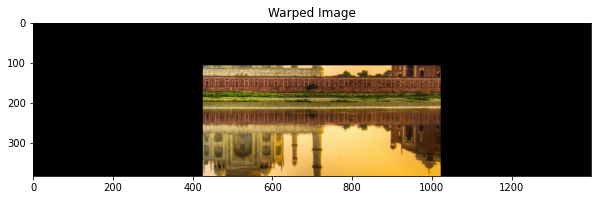

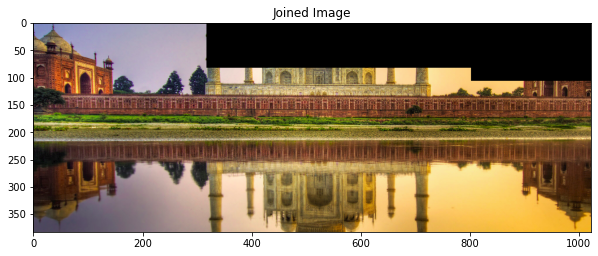

In [8]:
img2 = cv.imread('../images/Image Mosaicing/2_6.png')
img1 = joinImages(img1, img2, True)

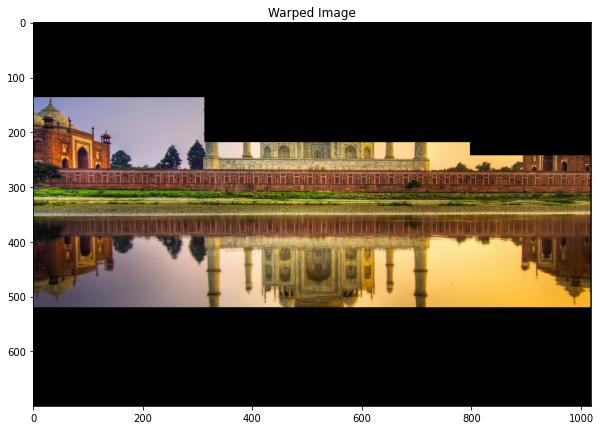

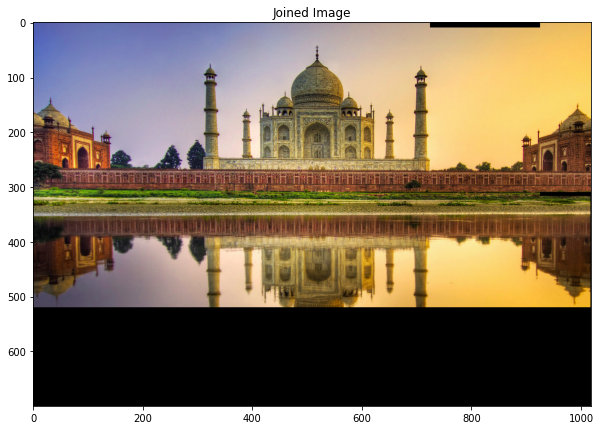

In [9]:
img1 = joinImages(upper, img1, False)

### Image Set 3

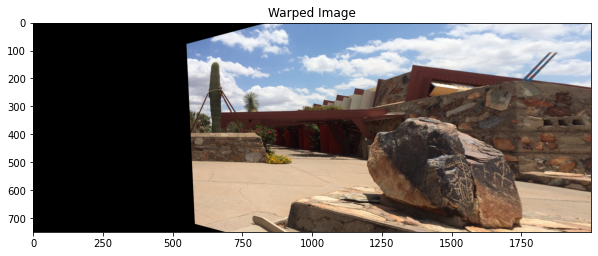

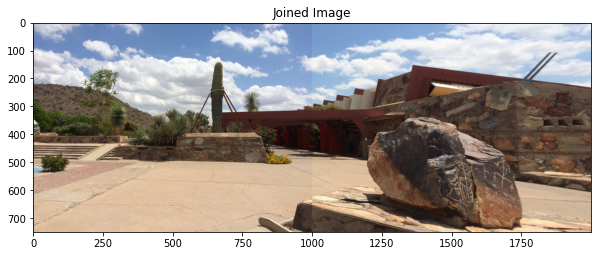

In [10]:
img1 = cv.imread('../images/Image Mosaicing/3_1.png')
img2 = cv.imread('../images/Image Mosaicing/3_2.png')
img1 = joinImages(img1, img2, True)

### Image Set 4

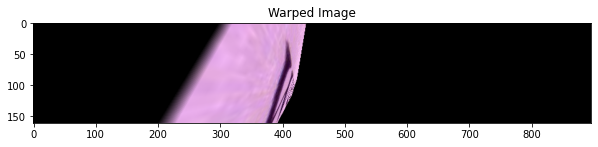

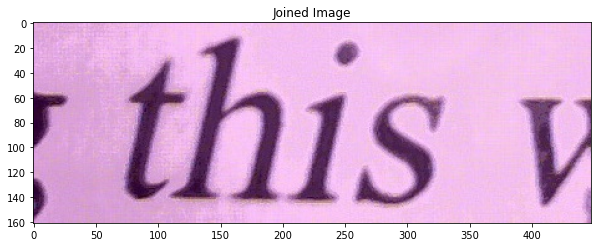

In [11]:
img1 = cv.imread('../images/Image Mosaicing/4_1.jpg')
img2 = cv.imread('../images/Image Mosaicing/4_2.jpg')
img1 = joinImages(img1, img2, True)

### Image Set 5

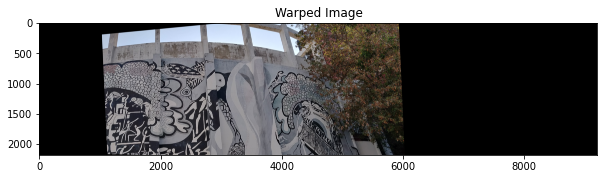

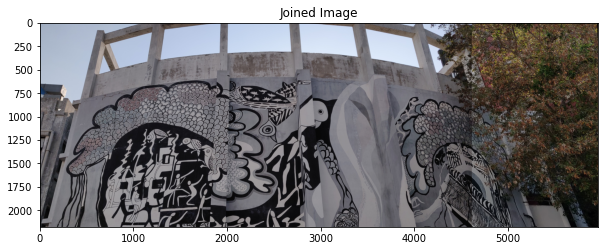

In [12]:
img1 = cv.imread('../images/Image Mosaicing/5_1.jpg')
img2 = cv.imread('../images/Image Mosaicing/5_2.jpg')
img1 = joinImages(img1, img2, True)

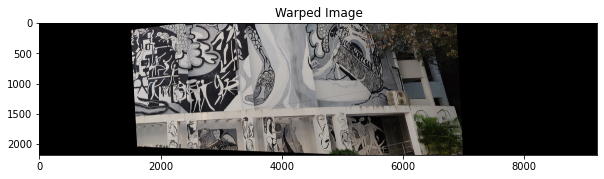

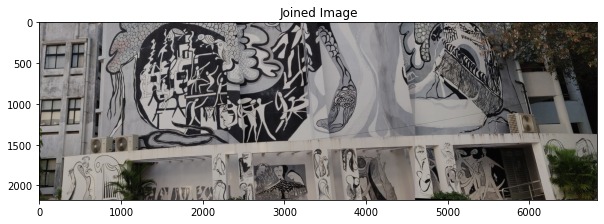

In [13]:
upper=img1.copy()
img1 = cv.imread('../images/Image Mosaicing/5_4.jpg')
img2 = cv.imread('../images/Image Mosaicing/5_3.jpg')
img1 = joinImages(img1, img2, True)

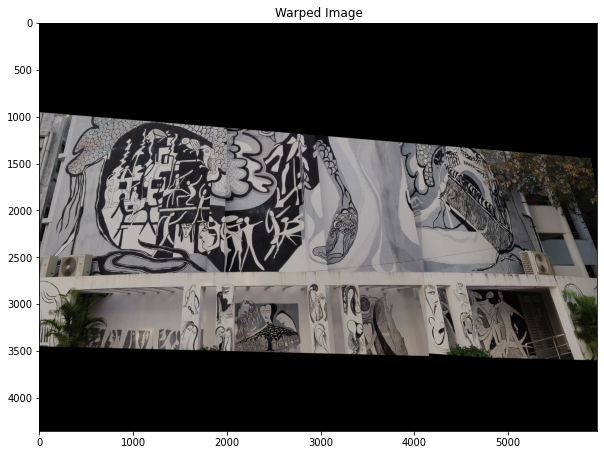

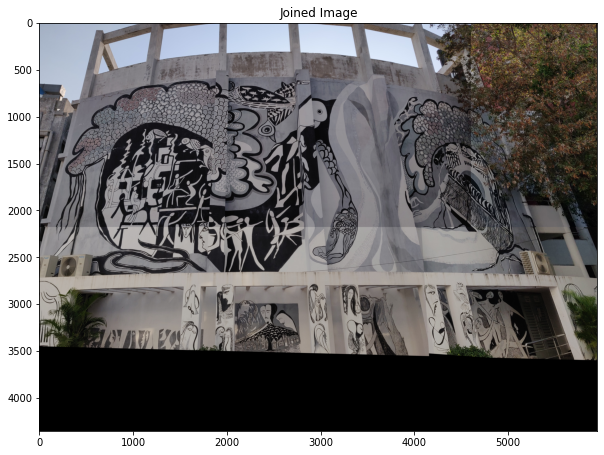

In [14]:
img1 = joinImages(upper, img1, False)

### Self-captured Image Set

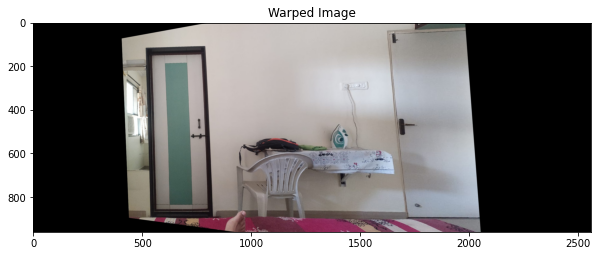

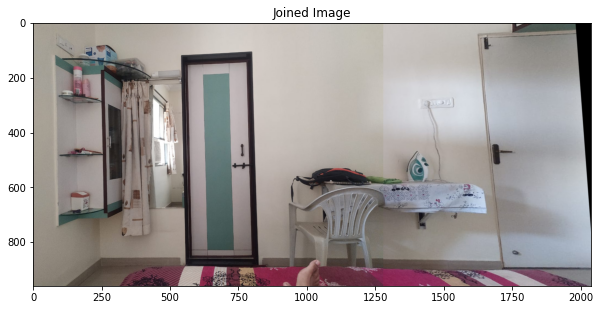

In [15]:
img1 = cv.imread('../images/Image Mosaicing/1.jpg')
img2 = cv.imread('../images/Image Mosaicing/2.jpg')
img1 = joinImages(img1, img2, True)